In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys,pickle,re
sys.path.append("/home/bruce1996/repo/LIHC_anomaly_detection/")
from utils.gsea import *

### pre-processing

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/LIHC_coding_gene_fpkm.txt",sep='\t',index_col=0)
metadata = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/sample_info/sample_info_df.txt",sep='\t',index_col=0)
vote = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/ensemble_learning_result/ensemble_hbv_only_np_ratio_35_vote_result.txt",sep='\t',index_col=0)
voted_gene = list(set(vote.index[vote['Vote'] > 0]).intersection(exp_m.index))
non_voted_gene = list(set(exp_m.index) - set(voted_gene))

In [4]:
samples = metadata['Sample'][np.where((metadata['Label'] == 'Tumor'),True,False)]
target_m = exp_m.loc[:,samples]
metadata = metadata.loc[np.where((metadata['Label'] == 'Tumor'),True,False),:]
y = np.where(metadata['HBV'] =='Positive',1,0)
scaler = StandardScaler()
std_x = scaler.fit_transform(target_m.T.to_numpy())
std_m = pd.DataFrame(std_x,index=target_m.columns,columns = target_m.index).T

### Single sample GSEA processing

In [6]:
def edge2node(edge_context) :
    '''
    edge_list : str, like 'ENSG00000115415 ENSG00000138496_ENSG00000115415 ENSG00000168961_ENSG00000115415, underline as seperator
    '''
    edge_l = edge_context.split('_')
    node_l = set(list(map(lambda x : x.split(' ')[0],edge_l)) + list(map(lambda x : x.split(' ')[1],edge_l)))
    return list(node_l)

In [23]:
vote_m = std_m.loc[voted_gene,:]
ppi = 'GRN'
module_excel = pd.ExcelFile("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/functional_module_summary/Summary_table_of_%s_FunModu.xlsx" % ppi)
module_info = pd.read_excel(module_excel,sheet_name='hbv_only_35')
module_gene_dict = dict(zip(module_info['Description'],[edge2node(module_info['Edges'][idx]) for idx in range(module_info.shape[0])]))

In [ ]:
sample_gsea_res = {}
for idx,sample in enumerate(vote_m.columns) :
    print("%d st single sample GSEA for single : %s" % (idx,sample))
    gene_ranking = list(vote_m[sample].sort_values(ascending=False).index)
    sample_gsea = gene_set_enrichment_analysis(cluster_component=module_gene_dict,ranking=gene_ranking)
    sample_gsea.gsea()
    sample_gsea_res[sample] = sample_gsea

es_z_matrix = np.zeros([len(sample_gsea_res),len(sample_gsea_res['AACV'].cluster_component)],dtype=np.float16)
for idx,sample in enumerate(sample_gsea_res.keys()) :
    tmp = sample_gsea_res[sample]
    es_zscore = (tmp.es_score_median - tmp.es_score) / tmp.es_score_std
    es_z_matrix[idx,:] = es_zscore
es_z_df = pd.DataFrame(es_z_matrix,index=list(sample_gsea_res.keys()),columns=list(sample_gsea_res['AACV'].cluster_component.keys()))
es_z_df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/module_gene_hbv_prediction/%s_module_single_sample_gsea_zscore.txt" % ppi,sep='\t')

### Prediction HBV status by module GSEA z-score

In [29]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [3]:
grn_gsea_z = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/module_gene_hbv_prediction/%s_module_single_sample_gsea_zscore.txt" % 'GRN',sep='\t',index_col=0)
pin_gsea_z = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/module_gene_hbv_prediction/%s_module_single_sample_gsea_zscore.txt" % 'PIN',sep='\t',index_col=0)
es_z_df = pd.concat([grn_gsea_z,pin_gsea_z],axis=1)

In [ ]:
metrices = ['accuracy',"f1","precision","recall"]
clf_dict = {'LogisticRegression' : LogisticRegression(max_iter=2000),'SVM' : SVC(),'RandomForest' : RandomForestClassifier()}
clf_metric = {'LogisticRegression' : pd.DataFrame(np.zeros([10,4]),columns=metrices),
              'SVM' : pd.DataFrame(np.zeros([10,4]),columns=metrices),
              'RandomForest' : pd.DataFrame(np.zeros([10,4]),columns=metrices)}

x = es_z_df.loc[metadata['Sample'],:].to_numpy()
y = np.where(metadata['HBV'] =='Positive',1,0)
for clf_name,clf in clf_dict.items() :
    cv_res = cross_validate(clf,x,y,cv=10,scoring=metrices)
    for metric in metrices :
        clf_metric[clf_name][metric] = cv_res["test_" + metric]
tmp = pd.DataFrame()
for clf_name,df in clf_metric.items() :
    df['Classifier'] = [clf_name] * df.shape[0]
    tmp = pd.concat([tmp,df])
plot_df = tmp.melt(id_vars='Classifier')


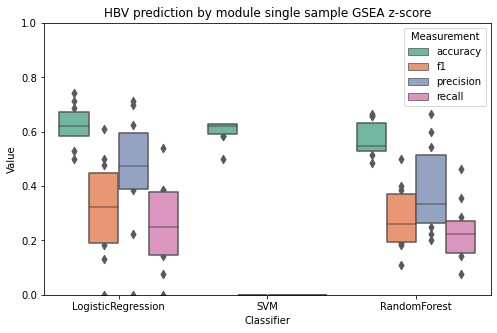

In [41]:
plot_df.columns = ['Classifier','Measurement','Value']
plt.figure(figsize=(8,5))
sns.boxenplot(data=plot_df,x='Classifier',y='Value',hue='Measurement',palette='Set2')
plt.ylim([0,1])
plt.title("HBV prediction by module single sample GSEA z-score")
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/module_gene_hbv_prediction/module_single_sample_gsea_zscore.png",dpi=300)

### PCA of single cell GSEA z-score

In [18]:
from sklearn.decomposition import PCA

In [4]:
grn_gsea_z = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/module_gene_hbv_prediction/%s_module_single_sample_gsea_zscore.txt" % 'GRN',sep='\t',index_col=0)
pin_gsea_z = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/module_gene_hbv_prediction/%s_module_single_sample_gsea_zscore.txt" % 'PIN',sep='\t',index_col=0)
es_z_df = pd.concat([grn_gsea_z,pin_gsea_z],axis=1)

In [5]:
clinical_file = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/sample_info/tmp.txt",sep='\t',index_col=0)
clinical_file = clinical_file.iloc[1:,:]
clinical_file.index = clinical_file['patient_id']
survival_col = ['vital_status','days_to_initial_pathologic_diagnosis','days_to_death','days_to_last_followup','pathologic_stage','gender','age_at_initial_pathologic_diagnosis','race','viral_hepatitis_serology']
survival_data = clinical_file.loc[:,survival_col]
survival_data['HBV'] = np.where([re.search('Hepatitis B Surface Antigen',x) for x in survival_data['viral_hepatitis_serology']],'Positive','Negative')

include_idx = survival_data['days_to_initial_pathologic_diagnosis'] == '0'
exclude_patient = list(survival_data.index[~include_idx])
survival_data = survival_data.loc[include_idx,:].copy()
### exclude crterion : both days_to_death & days_to_followup is missing value
#change days_to_death/days_to_last_followup to numeric
def numeric_survival(r) :
    if 'Not' not in r['days_to_death'] :
        return int(r['days_to_death'])
    else :
        return int(r['days_to_last_followup'])

survival_data['Survival_day'] = survival_data.apply(numeric_survival,axis=1)
# Status == True means patient dead in study period,else is False
survival_data['Status'] = np.where(survival_data['vital_status'] == 'Dead',True,False)
include_idx = np.where(survival_data['Survival_day'] > 0,True,False)
survival_data = survival_data.loc[include_idx,:].copy()

survival_col = ['pathologic_stage','gender','race','viral_hepatitis_serology']
survival_data = clinical_file.loc[:,survival_col]
survival_data['HBV'] = np.where([re.search('Hepatitis B Surface Antigen',x) for x in survival_data['viral_hepatitis_serology']],'Positive','Negative')

survival_data['pathologic_stage'].unique()
stage_without_subclass = ['Not Available', 'Stage I', 'Stage II', 'Stage III', 'Stage III',
       'Not Available', 'Stage III', 'Stage IV', 'Stage III','Stage IV', 'Stage IV']
stage_d = dict(zip(survival_data['pathologic_stage'].unique(),stage_without_subclass))

race_d = dict(zip(survival_data['race'].unique(),
                  ['ASIAN', 'WHITE', 'BLACK OR AFRICAN AMERICAN', 'Unknown','Unknown', 'Unknown', 'AMERICAN INDIAN OR ALASKA NATIVE']))
survival_data['Stage'] = survival_data['pathologic_stage'].map(stage_d)
survival_data['Race'] = survival_data['race'].map(race_d)
metadata = survival_data.loc[es_z_df.index,['Status','','gender','Race','HBV','Stage']]

In [8]:
cox_regression_df = pd.concat([metadata,es_z_df],axis=1)
cox_regression_df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/module_gene_hbv_prediction/cox_module_single_sample_gsea_zscore_pca.txt",sep='\t')

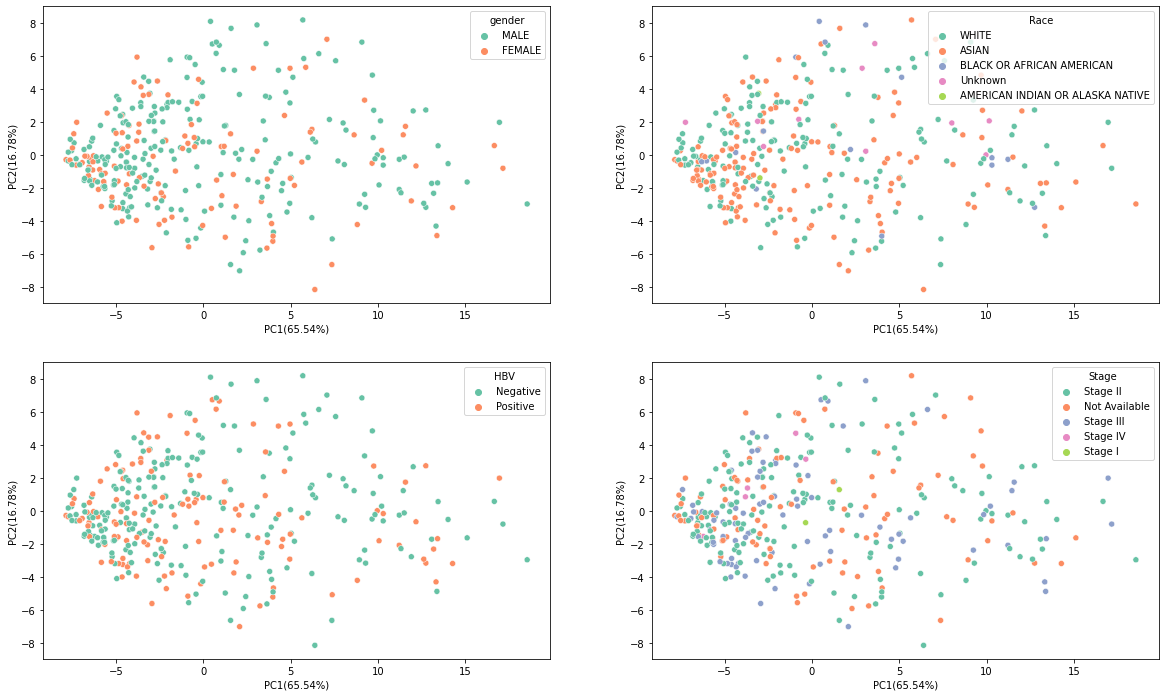

In [26]:
pca = PCA(n_components=2)
pca_res = pca.fit_transform(es_z_df.to_numpy())
plot_df = pd.concat([pd.DataFrame(pca_res,index=es_z_df.index,columns=['PC1','PC2']),metadata],axis=1)

fig,axes = plt.subplots(2,2,figsize=(20,12))
conditions = list(plot_df.columns[2:])
for idx,axs in enumerate(axes.ravel()) :
    sns.scatterplot(data=plot_df,x = 'PC1',y = 'PC2',hue=conditions[idx],palette="Set2",ax=axs)
    axs.set_xlabel("PC1({:.2f}%)".format(100 * pca.explained_variance_ratio_[0]))
    axs.set_ylabel("PC2({:.2f}%)".format(100 * pca.explained_variance_ratio_[1]))
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/module_gene_hbv_prediction/module_single_sample_gsea_zscore_pca.png",dpi=300)